### This notebook uses the idea of Siamese NN. The Siames network was built to check if two images are similar. We hope to use the same idea to check if two records are similar.

The Notebook is arranged as follows:
- **Importing packages**: This step involves importing the necessary packages into this python environment.
- **Preprrocessing steps**: Load the two dataframes, convert the dates to day, month and year, and finally replace the missing values in names with an empty string. The names are converted to vectors using the position they hold in the alphabet. For example 'Jane'--> (10,1,14,5). 
 - The vector size 15(Possible the longest name in the dataset, the characters after the maximum length is reached should discarded) is initially initialized to zeros. 
 - The initialized values are populated as in the example of Jane. The vectors are scaled by dividing by 26 (value for z). We admit that the encoding of names this way is not the best but a good start towards a robust way.  Once the encoding happens, we update the values in the dataframe. 
 - Dropping the unnecessary columns such as record number, ID and names.
- **Upload the labels**: This are the labels that were generated using the first method (As mentioned, they were to be used).
- **Filter the data**: Filter the dataframes using the indices in the label datase for proper label matching. After this happens we split the data into training (70%) and testing(30%).
- **Label Encoding**: The model will output three labels hence we need to label encode our target. For this we set match values to (1,0,0), partial match to (0,1,0) and unmatch to (0,0,1).
- **Initilize the feedforward network**: For this task we replace the CNN model with a feed forward neurl network with two layers. The number of neurons in each layer is choosen so that the model does not overfit on our small dataset.
- **Set up the siamese network**: Build the siamese model with two networks one for hdss data and the other for the facility data. The outputs of the two networks is through an L1 norm to compute the difference. The L1norm is finally taken through a fully connected layer of 3 neurons corresponding to the number of classes.
 - **Compile and Fit the model**: The model is compiled with adam optimizer and categorical_crossentropy as the loss. After compiling fit the model on the training data (for epochs you choose ). Recall that the input features is a list of two arrays (one for the hdss data and the other facility data) and encoded labels.
 - **Model evaluation**: The model was evaluated using the test set had an accuracy of **93.05** and an accuracy of **92.76%**
 
 - **Retrospect**: This step involves going through some prediction to see why error were made during predictions.
 
 ## Final Thought.
 This method has a great potential to perform record linkage. More labeled data is needed to train a robust model. 

## Import the necessary packages

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import recordlinkage
import datetime as dt
from sklearn.metrics import confusion_matrix,f1_score
import random

import warnings
warnings.filterwarnings('ignore')
##
import keras as k
from keras.layers import *
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.optimizers import Adam
import tensorflow as tf

## Preprocessing step

In [123]:
#year, month, and day column
def connvert_date(hdss):
    hdss['dob']=pd.to_datetime(hdss['dob'],dayfirst=True)
    hdss['year']=hdss['dob'].dt.year
    hdss['month']=hdss['dob'].dt.month
    hdss['day']=hdss['dob'].dt.day
    return hdss.drop('dob',axis=1)

In [234]:
hd_master=pd.read_csv('data/synthetic_hdss_v3.csv')

fac_master=pd.read_csv('data/synthetic_facility_v3.csv')


In [124]:
#import the dataset, replace Nan with an empty string
#and convert the dates
or_hdss=pd.read_csv('data/synthetic_hdss_v3.csv')
or_hdss.replace(np.NaN,'',inplace=True)
or_hdss=connvert_date(or_hdss)
or_facility=pd.read_csv('data/synthetic_facility_v3.csv')
or_facility.replace(np.NaN,'',inplace=True)
or_facility=connvert_date(or_facility)

In [125]:
#list of alphbets
code=list('abcdefghijklmnopqrstuvwxyz')

In [126]:
#create a function that can be used to convert names to vectors
size=15
def convert_name_to_vector(name):
    name=name.lower()
    initials=np.zeros(size)
    i=0
    for a in name:
        if a in code:
            value=code.index(a)+1
            initials[i]=value
            i+=1
    return (initials/26).flatten()

In [127]:
#generate the column names for the vectors
first=[]
last=[]
pet=[]
for i in range(size):
    first.append(f'f_{i}')
    last.append(f'l_{i}')
    pet.append(f'p_{i}')

In [128]:
#copy the dataframe, for future use
master_hdss=or_hdss.copy()
master_facility=or_facility.copy()

In [129]:
#convert the names to vectors. Initiliazed vector of size 15
or_hdss[first]=pd.DataFrame(or_hdss['firstname'].apply(convert_name_to_vector).tolist())
or_hdss[last]=pd.DataFrame(or_hdss['lastname'].apply(convert_name_to_vector).tolist())
or_hdss[pet]=pd.DataFrame(or_hdss['petname'].apply(convert_name_to_vector).tolist())

or_facility[first]=pd.DataFrame(or_facility['firstname'].apply(convert_name_to_vector).tolist())
or_facility[last]=pd.DataFrame(or_facility['lastname'].apply(convert_name_to_vector).tolist())
or_facility[pet]=pd.DataFrame(or_facility['petname'].apply(convert_name_to_vector).tolist())

In [130]:
#drop the unnecessary columns
hdss=or_hdss.drop(['recnr','firstname', 'lastname', 'petname', 'hdssid','hdsshhid','nationalid'],axis=1)
facility=or_facility.drop(['recnr', 'firstname', 'lastname', 'petname','nationalid','patientid', 'visitdate',],axis=1)

### Label Upload and training  set generation

In [131]:
#load the labels. This labels we generated using the record linkage library method method
#read the labeled_file
labeled=pd.read_csv('index_labels.csv')

In [132]:
#fecth the indices and the corresponding labels
hd_index=np.array(labeled['0'])
fc_index=np.array(labeled['1'])
label=np.array(labeled['labels'])

In [133]:
#filter the pairs and label them as match, partial or different(unmatch)
pairs=np.array(list(zip(hd_index,fc_index)))
match=pairs[label==1]
partial=pairs[label==0]
different=pairs[label==-1]

In [134]:
pairs

array([[   0, 2501],
       [   3, 1079],
       [   4, 1012],
       ...,
       [4114,  591],
       [4114, 1537],
       [4114, 1801]])

### Creat the training and testing set

In [135]:
#function to filter the data from the large dataframe
def generate_data(match,label):
    hds=hdss.loc[match[:,0]]
    fac=facility.loc[match[:,1]]
    labels=[label]*fac.shape[0]
    return hds,fac,labels

In [136]:
#filter the data and for all labels
hds_match,fac_match,lab_match=generate_data(match,1)
hds_part,fac_part,lab_part=generate_data(partial,0)
hds_diff,fac_diff,lab_diff=generate_data(different,-1)

In [137]:
#concat the files to have one for each i.e. hdss and facility.
#remember the this is the data where label is available
hdss_combo=pd.concat([hds_match,hds_part,hds_diff])
facility_combo=pd.concat([fac_match,fac_part,fac_diff])
label_combo=np.array(lab_match+lab_part+lab_diff)

In [138]:
#sample the training set which is 70% of the entire data set
#generate the indices which will be used for training and testing
random.seed(0)
train=random.sample(set(np.arange(hdss_combo.shape[0])),int(hdss_combo.shape[0]*0.7))
test=list(set(np.arange(hdss_combo.shape[0]))-set(train))

### Encode the labels

In [139]:
#encoding
one=[1,0,0]
zero=[0,1,0]
negative=[0,0,1]
label_combo_encoded=[]
for a in label_combo:
    if a==1:
        label_combo_encoded.append(one)
    elif a==0:
        label_combo_encoded.append(zero)
    else:
        label_combo_encoded.append(negative)

In [140]:
#split the test and trainin based on the indices produced earlier
hdss_combo_train=hdss_combo.iloc[train]
hdss_combo_test=hdss_combo.iloc[test]
facility_combo_train=facility_combo.iloc[train]
facility_combo_test=facility_combo.iloc[test]
label_combo_train=np.array(label_combo_encoded)[train]
label_combo_test=np.array(label_combo_encoded)[test]


In [141]:
#create the a list of pairs. For the siamese network.
#remember one side is hdss and the other is facility data
paired_train=[np.array(hdss_combo_train),np.array(facility_combo_train)]
paired_test=[np.array(hdss_combo_test),np.array(facility_combo_test)]

## Creat the Siamese feedforward network with two layers

In [142]:
def get_siamese_ffn_unit(input_shape):
    # Define the neural network architecture
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(16, activation='relu'),
    ])
    return model


In [143]:
#create a function that is able to separate the network into two,
# feed the list of inputs to the modela and softmax the output
def get_classifier_model(input_shape):
    """
        Model architecture
    """
    
    # Define the tensors for the two input vectors
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = get_siamese_ffn_unit(input_shape)
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:k.backend.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = tf.keras.layers.Dense(3, activation='softmax')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

### Compile and fit the model

In [146]:
ip_shape=hdss.shape[1]
model = get_classifier_model(ip_shape)
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model
history=model.fit(paired_train, label_combo_train, epochs=100,batch_size=32, validation_split=0.2)


Epoch 1/100
54/54 [==============================] - 1s 12ms/step - loss: 0.9170 - accuracy: 0.7388 - val_loss: 0.8629 - val_accuracy: 0.8279
Epoch 2/100
54/54 [==============================] - 0s 3ms/step - loss: 0.8481 - accuracy: 0.8173 - val_loss: 0.8471 - val_accuracy: 0.8233
Epoch 3/100
54/54 [==============================] - 0s 5ms/step - loss: 0.8304 - accuracy: 0.8168 - val_loss: 0.8262 - val_accuracy: 0.8256
Epoch 4/100
54/54 [==============================] - 0s 5ms/step - loss: 0.8093 - accuracy: 0.8179 - val_loss: 0.8057 - val_accuracy: 0.8256
Epoch 5/100
54/54 [==============================] - 0s 2ms/step - loss: 0.7870 - accuracy: 0.8168 - val_loss: 0.7818 - val_accuracy: 0.8279
Epoch 6/100
54/54 [==============================] - 0s 2ms/step - loss: 0.7666 - accuracy: 0.8168 - val_loss: 0.7588 - val_accuracy: 0.8302
Epoch 7/100
54/54 [==============================] - 0s 1ms/step - loss: 0.7432 - accuracy: 0.8173 - val_loss: 0.7326 - val_accuracy: 0.8302
Epoch 8/100


Epoch 59/100
54/54 [==============================] - 0s 1ms/step - loss: 0.1696 - accuracy: 0.9535 - val_loss: 0.2223 - val_accuracy: 0.9488
Epoch 60/100
54/54 [==============================] - 0s 2ms/step - loss: 0.1669 - accuracy: 0.9564 - val_loss: 0.2286 - val_accuracy: 0.9465
Epoch 61/100
54/54 [==============================] - 0s 1ms/step - loss: 0.1654 - accuracy: 0.9558 - val_loss: 0.2173 - val_accuracy: 0.9512
Epoch 62/100
54/54 [==============================] - 0s 1ms/step - loss: 0.1633 - accuracy: 0.9581 - val_loss: 0.2182 - val_accuracy: 0.9442
Epoch 63/100
54/54 [==============================] - 0s 1ms/step - loss: 0.1627 - accuracy: 0.9564 - val_loss: 0.2172 - val_accuracy: 0.9488
Epoch 64/100
54/54 [==============================] - 0s 1ms/step - loss: 0.1604 - accuracy: 0.9581 - val_loss: 0.2157 - val_accuracy: 0.9465
Epoch 65/100
54/54 [==============================] - 0s 1ms/step - loss: 0.1600 - accuracy: 0.9570 - val_loss: 0.2175 - val_accuracy: 0.9465
Epoch 

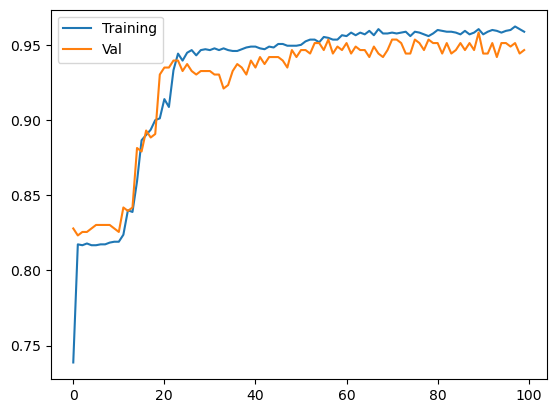

In [147]:
#training accuracy curve
plt.plot(history.history['accuracy'],label='Training')
plt.plot(history.history['val_accuracy'],label='Val')
plt.legend()
plt.show()

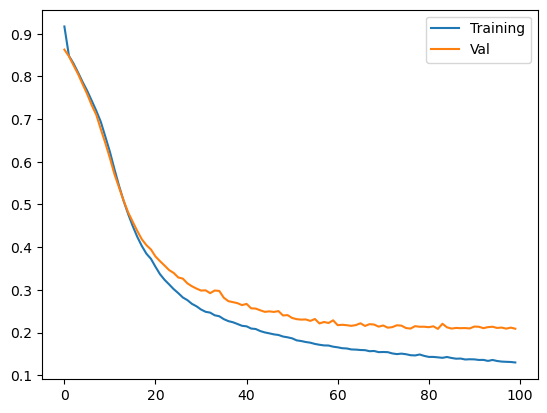

In [148]:
#loss curve
plt.plot(history.history['loss'],label='Training')
plt.plot(history.history['val_loss'],label='Val')
plt.legend()
plt.show()

### Evaluate the model on the test set

In [149]:
# Evaluate the model
test_loss, test_acc = model.evaluate(paired_test, label_combo_test)
print('Test accuracy:', test_acc)


29/29 [==============================] - 0s 1ms/step - loss: 0.1870 - accuracy: 0.9382
Test accuracy: 0.9381778836250305


In [150]:
### Compute an F1-Score on the test set and plot a heatmap

In [151]:
#create a confusion matrix
preds=np.argmax(model.predict(paired_test),axis=1)
act=np.argmax(label_combo_test,axis=1)

29/29 [==============================] - 0s 712us/step


In [152]:
#the f1 score
f1_score(act,preds, average='weighted')

0.9383512171599969

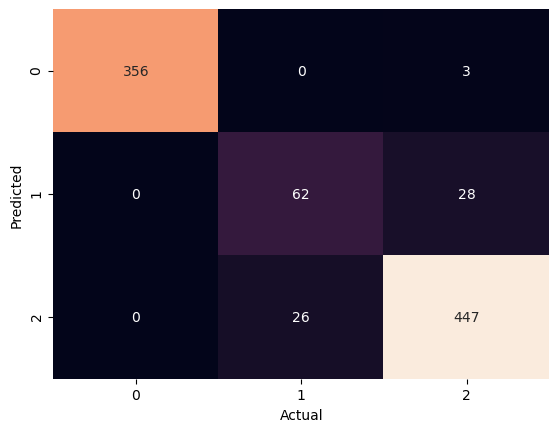

In [153]:
#test prediction heatmap
sns.heatmap(confusion_matrix(preds,act),annot=True,fmt='d',cbar=False)
plt.ylabel('Predicted')
plt.xlabel('Actual')

plt.show()

In [ ]:
## Retrospect

In [175]:
#choose the predicted class and actual class to see the entries of the confusion matrix above
indices = np.where((preds == 2) & (act == 0))[0]

In [176]:
indices

array([58])

In [134]:
## Test the model using random test data

In [192]:
#choose a value in the indices the abe and save it as rand
rand=58


In [180]:
#get the actual indices of the test record
t_h=hdss_combo.iloc[[rand]].index[0]
t_f=facility_combo.iloc[[rand]].index[0]

In [181]:
#display the record in the hdss file
master_hdss.loc[[t_h]]

,recnr,firstname,lastname,petname,sex,nationalid,hdssid,hdsshhid,year,month,day
213,214,Rose,Nakisuyi,Handa,2,,I20214,HH100214,1998,9,17


In [182]:
#display the record in the facility
master_facility.loc[[t_f]]

,recnr,firstname,lastname,petname,sex,nationalid,patientid,visitdate,year,month,day
191,193,Rose,Nakisuyi,Handa,2,N_ID_5534,2263,20-07-2019,1998,9,24


In [202]:
#runs this to see the probabilities of choosing a certain class
pred=model.predict([hdss.loc[[t_h]].values,facility.loc[[t_f]].values])
pred

1/1 [==============================] - 0s 16ms/step


array([[0.9648453 , 0.00883629, 0.02631845]], dtype=float32)

### Save the model.

In [60]:

import pickle
with open('saimese.pkl', 'wb') as file:
    pickle.dump(model, file)

In [61]:
# Load the trained classifier from the file
with open('saimese.pkl', 'rb') as file:
    classifier = pickle.load(file)

In [215]:
# load the pairs
candidate=pd.read_csv('pairs_test_1.csv')

In [216]:
candidate

,0,1
0,7,762
1,8,2091
2,12,2804
3,13,2798
4,14,772
...,...,...
1149,4086,2090
1150,4088,807
1151,4097,1031
1152,4103,1392


In [217]:
def get_hdss_and_facility(candidate_links,hdss,facility):
    hd,fc=candidate_links['0'],candidate_links['1']
    hdss=hdss.iloc[hd].values
    facility=facility.iloc[fc].values
    return [hdss,facility]

In [218]:
tester=get_hdss_and_facility(candidate,hdss,facility)

In [219]:
pss=classifier.predict(tester)

37/37 [==============================] - 0s 587us/step


In [224]:
xx=np.argmax(pss,axis=1)==1
sum(xx)

100

In [225]:
len(np.unique(candidate.iloc[xx]['0']))

86

In [226]:
candidate.iloc[xx]

,0,1
57,202,778
60,213,191
61,213,2198
64,221,2340
67,225,2581
...,...,...
826,2856,2712
831,2876,396
918,3221,1494
1005,3554,2082


In [243]:
hd_master.iloc[[2876]]

,recnr,firstname,lastname,petname,dob,sex,nationalid,hdssid,hdsshhid
2876,2877,Edirisa,Christopher,Muhairwe,03-07-1986 00:00,1,NaN,I22877,HH102877


In [244]:
fac_master.iloc[[396]]

,recnr,firstname,lastname,petname,dob,sex,nationalid,patientid,visitdate
396,398,Edirisa,Christopher,Muhairwe,10-07-1986 00:00,1,N_ID_6155,2468,05-11-2019
